[0.95 0.9  0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35]
[np.float64(0.5597230796073251), np.float64(1.4656351240365895), np.float64(3.729785874755551), np.float64(7.082217894679774), np.float64(9.025053868829122), np.float64(10.392388017751578), np.float64(11.015855969303193), np.float64(11.377518663028095), np.float64(11.532230038850857), np.float64(11.526067280726904), np.float64(11.505226802215763), np.float64(11.490471496498863), np.float64(11.466316919487294)]


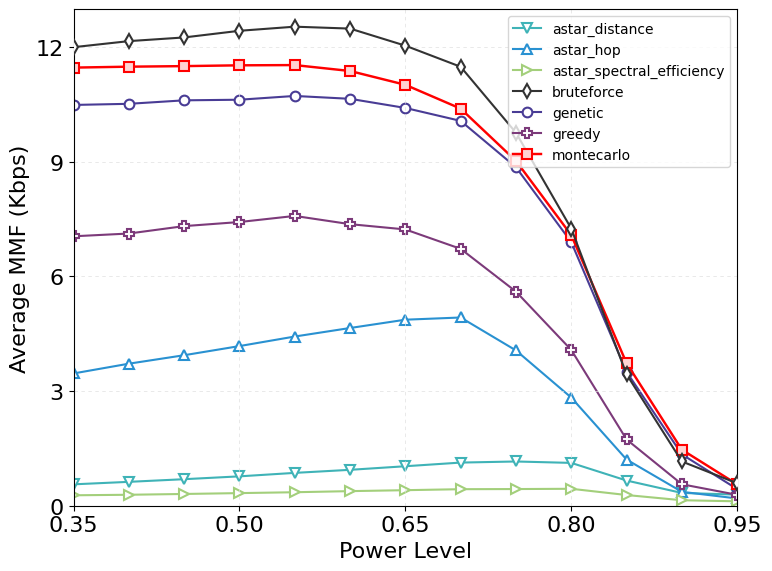

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# All comments and explanations in English
# This script plots the final results from mmf_vs_power.py experiments.
# The directories are assumed to be structured like:
#  ./results_mmf_vs_power
#    |- env
#    |- power_0.9
#         |- exp_000
#             |- result.json
#         |- exp_001
#             |- result.json
#    |- power_0.8
#         |- exp_000
#         ...
#
# We collect and average the throughputs from each scheme, then plot them as a function of power level.

fontsize = 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize

# Marker and color lists
marker_list = ['v', '^', '>', 'd', 'o', 'P', 's', 'X']
color_list = ["#3FB3B7", "#2991D1", "#A3CF7B", "#333333", "#493C95", "#7C3A7A", "#FF0000"]

# Base directory where mmf_vs_power.py experiment results are saved
base_dir = "/fast/hslyu/results_mmf_vs_power"

# Define the power levels used in mmf_vs_power.py
# The script there used np.arange(0.95, 0.49, -0.05)
power_levels = np.arange(0.95, 0.34, -0.05)
print(power_levels)

# Dictionary to store average throughput per scheme for each power level
results_by_power = {}

# Loop through each power level directory and parse experiment results
for pwr in power_levels:
    dir_name = f"power_{pwr:.2f}"
    pwr_path = os.path.join(base_dir, dir_name)

    if not os.path.isdir(pwr_path):
        continue

    # Gather all experiment directories
    exp_dirs = [
        d for d in os.listdir(pwr_path)
        if d.startswith("exp_") and os.path.isdir(os.path.join(pwr_path, d))
    ]

    scheme_results = {}

    for exp_dir in exp_dirs:
        result_file = os.path.join(pwr_path, exp_dir, "result.json")
        if not os.path.isfile(result_file):
            continue
        with open(result_file, "r") as f:
            result_data = json.load(f)
        # Accumulate results for each scheme
        for scheme_name, throughput_value in result_data.items():
            if scheme_name not in scheme_results:
                scheme_results[scheme_name] = []
            scheme_results[scheme_name].append(throughput_value)

    # If we have any results, compute average throughput for each scheme
    if scheme_results:
        avg_results = {}
        for scheme_name, values in scheme_results.items():
            # Convert to Kbps
            avg_thpt_kbps = np.mean(values) / 1000.0
            avg_results[scheme_name] = avg_thpt_kbps
        results_by_power[pwr] = avg_results

# Collect all schemes across the entire data set
all_schemes = set()
for val in results_by_power.values():
    all_schemes.update(val.keys())
all_schemes = sorted(list(all_schemes))

# Prepare plot
plt.figure(figsize=(8, 6))

for i, scheme in enumerate(all_schemes):
    # Gather average throughput in Kbps across power levels
    y_vals = []
    for pwr in power_levels:
        y_vals.append(results_by_power.get(pwr, {}).get(scheme, np.nan))
    
    if scheme == "montecarlo":
        print(y_vals)
    # In the original mmf_vs_spsc-graph.py some specific zorder and style customizations were done.
    # We'll apply a simpler version here; you can customize below if desired.
    zorder = 1
    linewidth = 1.5
    markerfacecolor = "w"
    markersize = 7

    # Example special style for certain schemes if you wish:
    if scheme == "montecarlo":
        markerfacecolor = "#FFD4D4"
        linewidth = 1.75
        markersize = 7.5
        zorder=2
    elif scheme == "greedy":
        markerfacecolor = 'w'
        markersize = 7.5
    elif scheme == "bruteforce":
        zorder = 3
    else:
        markerfacecolor = "w"
        markersize = 7


    plt.plot(
        power_levels, y_vals,
        linewidth=linewidth,
        marker=marker_list[i % len(marker_list)],
        markersize=markersize,
        markerfacecolor=markerfacecolor,
        markeredgewidth=1.5,
        color=color_list[i % len(color_list)],
        label=scheme,
        zorder=zorder
    )

# Configure axes, labels, and ticks
plt.xlabel("Power Level")
plt.ylabel("Average MMF (Kbps)")
plt.xlim(0.5, 0.95)
plt.ylim(0, 13)
plt.xticks(np.arange(0.35, .96, 0.15))
plt.yticks(np.arange(0, 13, 3))
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.grid(True, which='both', linestyle=(0, (5, 5)), linewidth=0.5, color="#e0e0e0")
plt.legend(fontsize=10, loc='best')
plt.tight_layout()

# Save the figure as EPS
# output_filename = "mmf_vs_power_plot.eps"
# plt.savefig(output_filename, format='eps', dpi=300, bbox_inches='tight')
plt.show()
